Загрузим необходимый функционал

In [149]:
import gc
import joblib
import warnings

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from src import utils
from collections import Counter
from tqdm import (notebook, tqdm)
from matplotlib import pyplot as plt

tqdm.pandas()
warnings.filterwarnings("ignore")

<h1 align="center">Анализ данных о картодержателях и генерация таргета</h1>

Загрузим данные, посмотрим на размерность и потребление памяти

In [2]:
card_info = pd.read_csv("data/objects_cup.csv")
print(f"[Размерность]: {card_info.shape}")
print(f"[Потребление памяти]: {round(card_info.memory_usage().sum() / 1024 ** 2, 3)} Мб")

[Размерность]: (618366, 4)
[Потребление памяти]: 18.871 Мб


По памяти довольно терпимо

Посмотрим на 5 случайно отобранных строк

In [3]:
card_info.sample(5)

,card_uk,cardapp_date,owner_id,holder_id
418389,2.199436e+11,2022-02-18,732303e54409d857b59f0b984eea045a30031c1b88c5f3...,732303e54409d857b59f0b984eea045a30031c1b88c5f3...
196233,2.164175e+11,2021-11-01,7ef90ab9d29c006fbf3dff8d34551bcc900c9bf99c2d21...,7ef90ab9d29c006fbf3dff8d34551bcc900c9bf99c2d21...
553638,1.102632e+11,2020-11-03,b5c43bcfb547de8f604d36be7c8fe062e6ccb00cbf0c22...,b5c43bcfb547de8f604d36be7c8fe062e6ccb00cbf0c22...
102383,1.919450e+11,2021-08-10,aee99f920469f89d26c2cefc1c05eea20082dc3371f58f...,aee99f920469f89d26c2cefc1c05eea20082dc3371f58f...
76291,1.929897e+11,1900-01-01,fd2baff1d6f42c7dcd2efcbcec398fd8887718af28be71...,fd2baff1d6f42c7dcd2efcbcec398fd8887718af28be71...


Значит, имеем дело со следующей структурой таблички:
 - card_uk - идентификатор карты;
 - cardapp_date - дата выдачи карты;
 - owner_id - идентификатор владельца карты;
 - holder_id - идентификатор держателя карты
    
Посмотрим на количество уникальных значений по каждому столбцу

In [4]:
for col in tuple(card_info):
    print(f"[{col}]: {card_info[col].nunique()}")

[card_uk]: 618366
[cardapp_date]: 3211
[owner_id]: 489932
[holder_id]: 509235


Значит:
 - на одного владельца может приходиться несколько держателей карт;
 - один держатель может иметь несколько карт
 - возможно присутствуют данные, которые могут говорить о том, что срок действия карты истёк и её пришлось перевыпускать

Возьмём самое большое и самое маленькое значение card_uk и оценим кол-во цифр (card_uk вполне может быть номером карты)

In [5]:
len(str(card_info["card_uk"].max())), len(str(card_info["card_uk"].min()))

(14, 12)

Значит, card_uk - это всего лишь индекс, взятый из определённой базы данных, поэтому для дальнейшего анализа он не нужен

In [6]:
card_info.drop(["card_uk"], axis=1, inplace=True)
gc.collect();

Посмотрим, имеются ли дубликаты в данных

In [7]:
card_info.duplicated().sum()

13831

Дубликаты в данных присутствуют, посмотрим на них

In [8]:
card_info.loc[card_info.duplicated()]

,cardapp_date,owner_id,holder_id
609,2023-02-21,750f3a1774e0bca6ceb8c49356af8dd79f94e0e1fd054e...,2d539a4c8b322285979f67ead95bc7adfc97c9909a523e...
624,2023-02-21,750f3a1774e0bca6ceb8c49356af8dd79f94e0e1fd054e...,2d539a4c8b322285979f67ead95bc7adfc97c9909a523e...
890,2019-09-11,96920398f3a14cf6e0d6df98ab422e299ac50585c225b7...,96920398f3a14cf6e0d6df98ab422e299ac50585c225b7...
2270,2023-02-21,750f3a1774e0bca6ceb8c49356af8dd79f94e0e1fd054e...,2d539a4c8b322285979f67ead95bc7adfc97c9909a523e...
2832,2023-02-21,750f3a1774e0bca6ceb8c49356af8dd79f94e0e1fd054e...,2d539a4c8b322285979f67ead95bc7adfc97c9909a523e...
...,...,...,...
618299,2022-07-01,cf6d44daf5b60df9a27491de719f3af8049377def18f73...,cf6d44daf5b60df9a27491de719f3af8049377def18f73...
618315,2021-11-26,070320b8219bc884e1bf311aa63dad176a790de391da02...,070320b8219bc884e1bf311aa63dad176a790de391da02...
618316,2019-03-22,78da10c3eb916f2ad8e2bdd9bd81c18299b45bba60efcd...,78da10c3eb916f2ad8e2bdd9bd81c18299b45bba60efcd...
618351,2019-06-06,eecd9b7ebdfdbfe33ddd3a9c7243ce3ec9cf48ebed0a8d...,eecd9b7ebdfdbfe33ddd3a9c7243ce3ec9cf48ebed0a8d...


Из этой таблицы отлично видно, что некоторые строки полностью идентичны друг другу

Новой дополнительной информации эти строки не несут, однако увеличивают расход памяти, поэтому удалим их

In [9]:
card_info.drop_duplicates(inplace=True)
gc.collect();

Посмотрим, какие даты присутствуют в данных

In [10]:
card_info["cardapp_date"].value_counts().to_frame().reset_index().sort_values(by="index")

,index,cardapp_date
0,1900-01-01,3593
3097,2011-08-25,1
3128,2011-09-03,1
3096,2011-09-21,1
3159,2011-09-27,1
...,...,...
1879,2023-03-11,52
2043,2023-03-12,26
1927,2023-03-13,44
2082,2023-03-14,21


Присутствует очень странная дата - 01.01.1900, хотя дата учреждения Альфа банка 20.12.1990.
01.01.1900 - может быть значение по умолчанию для даты в некоторых базах данных, например, в MS SQL Server, поэтому удалим строки, связанные с этой датой и приведём индексацию таблицы в порядок

In [11]:
card_info = card_info[card_info["cardapp_date"] != "1900-01-01"]
card_info.reset_index(drop=True, inplace=True)
gc.collect();

Посмотрим, имеются ли пропуски в данных

In [12]:
card_info.isna().sum()

cardapp_date    1590
owner_id           0
holder_id          0
dtype: int64

Пропуски есть лишь по признаку "дата выдачи карты", посмотрим, что это за строки

In [13]:
card_info.loc[card_info["cardapp_date"].isna()]

,cardapp_date,owner_id,holder_id
434,NaN,a47b921a8563ebb5a469baac084878dc5ded9860f347ff...,a47b921a8563ebb5a469baac084878dc5ded9860f347ff...
1031,NaN,62a5d8cf48400cfc330fbd2d18fa7429a3c4033f88864e...,cb5e56ffb8d947f12a0527a024f378d9dbbcec4ef36ca8...
1058,NaN,476c44ba96f2f2cf9edecd0cefc056a6e75cd06a450241...,476c44ba96f2f2cf9edecd0cefc056a6e75cd06a450241...
1174,NaN,873bfccee7acc2dbfebb5d9ba176065022f21b20d0cd51...,873bfccee7acc2dbfebb5d9ba176065022f21b20d0cd51...
1992,NaN,73f02d19156af3c629494f1a754d6fc1ed1e2f600d2e22...,eb0e444382ea1604851669584c9035c4bf7ff6d96c4f2d...
...,...,...,...
598540,NaN,be8735b1d841e17b50ad3512ed338efb5a81f572510124...,be8735b1d841e17b50ad3512ed338efb5a81f572510124...
598919,NaN,b5a940115a4fbf4e61f00fb780c63e04435f126e4f6bcf...,b5a940115a4fbf4e61f00fb780c63e04435f126e4f6bcf...
599337,NaN,e7616eff9e67e7a5af65945421707a7aa1d6c6baa071a3...,e7616eff9e67e7a5af65945421707a7aa1d6c6baa071a3...
599396,NaN,2a8aa4546776c2caa1b6d0c72c89fa74cd825721187e98...,2a8aa4546776c2caa1b6d0c72c89fa74cd825721187e98...


Пропуски в датах нам не нужны, т.к. в таком случае мы не сможем проверить корректность даты выдачи карты и отчётной даты сбора информации по пользователю.

Оценим, сколько держателей карт может приходится на одного владельца

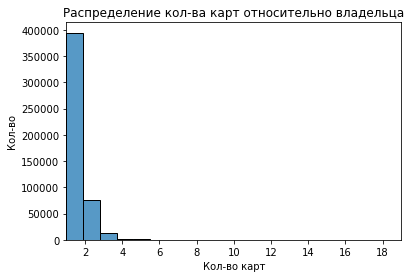

In [14]:
vals = card_info.groupby("owner_id").agg(
    count = ("holder_id", "count"))["count"]

sns.histplot(vals)
plt.xlim([vals.min(), vals.max()])
plt.xlabel("Кол-во карт")
plt.ylabel("Кол-во")
plt.title("Распределение кол-ва карт относительно владельца")
plt.show()

Вид распределения очень похож на экспоненциальное с $\lambda$ больше 1, однако это чисто опциональная информация

Значительная доля приходится на случай, когда на одного владельца приходится один держатель. Это может быть как сам владелец, который одновременно выступает в роли и держателя карты (<i>назовём это внутренней связью</i>), так и другой человек, т.е. имеем два разных физических лица (<i>назовём это внешней связью один к одному</i>).
Случай, когда на одного владельца приходится больше одного держателя может означать, что сам владелец имеет несколько карт (<i>назовём это внутренней связью псевдо один ко многим</i>), так и связь владельца с разными физическими лицами - держателями карт (<i>назовём это внешней связью один к многим</i>).

Также можно отметить, что вероятность того, что на одного владельца будет приходиться более трёх открытых держателей карт, крайне мала.

Используя эти данные, соберём целевую переменную для задачи бинарной классификации.
Для этого:
1) соберём айди держателей карт по каждому владельцу в список;
2) в цикле для каждого владельца карты пройдёмся по айди держателей карты и посчитаем кол-во невключений айди владельца в список айди держателей;
3) все положительные значения нового столбца - это положительный класс, иначе - отрицательный

In [15]:
target_df = card_info.groupby("owner_id").agg(
    lst = ("holder_id", list)
).reset_index()

In [16]:
res = []
for owner in notebook.tqdm(target_df.iterrows()):
    tmp= owner[1]["lst"]
    res.append(
        len(
            tuple(filter(lambda x: x != owner[1]["owner_id"], tmp))
        )
    )
target_df["tmp"] = res

del res
gc.collect();

0it [00:00, ?it/s]

In [17]:
target_df["target"] = target_df.tmp.progress_apply(lambda x: 1 if x > 0 else 0)

100%|██████████| 487247/487247 [00:00<00:00, 1368366.39it/s]


Удалим уже ненужные столбцы

In [18]:
target_df.drop(["lst", "tmp"], axis=1, inplace=True)
gc.collect();

Посмотрим на пять случайных строк с таргетом

In [19]:
target_df.sample(5)

,owner_id,target
51992,1b903e82b8095822adabc42c981130fb03aba06c4ba86d...,0
308230,a22f32099f742facb45cb9bb27b08d4d4bf829f2eff10d...,0
435439,e4d2a31d9de4e3bd424181663df98d5728d26c6672f46c...,0
121838,403b091563d39627eefae5a754d54651e321442a200f60...,0
390449,cd342e3f8021c7be821706c5ab2252e314d9c80a945ee9...,0


In [20]:
target_df.to_csv("target_last.csv", index=False)

Проверим корректность полученного таргета

In [21]:
all_df = card_info.merge(target_df, on="owner_id", how="left")
del card_info
gc.collect();

In [22]:
all_df[
    all_df["target"] == 1
]["owner_id"].value_counts()

b34fcb85141b96fff782b47d004588725301d5cadbd93da7f1fadc733e7e2aa8    19
31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd756def682a5a9f64d3c    18
c3bf65fe0251d3cd4d1c0cb6fc506c34b0dc799eef59d00535f5e52c14988c42    15
b31e1f4ec5e03ea2bcee5c6a31ee7501ebfd01acd5c5875cfbad6ca1986e34a6    15
15886874c9ccc2e178856bc8a23581664b29922bf5f745930adc04634607094f    13
                                                                    ..
62bcc9893eac077d0671c0aaa8d562a311dbdee435a9ad03561742f4a5b26b5b     1
281091bbae7d17313eb2c2a58fd4f766880e0a80a80955e8139ecd52b30c85bf     1
f36b9fde95db02d430c72f9d0de5fc3b2210ffcddf5733abcbc2d69b8bcc50fe     1
192a84465be6257bc6340ff3bec75572322e3bdb652a50ba543d0ce3c303f5b7     1
e9ff7f69d0592151a4cb317dafe3751556e7665a780cc9e36103d097ee43e931     1
Name: owner_id, Length: 100789, dtype: int64

In [23]:
all_df[
    all_df["owner_id"] == "e6e9ab15782ad1a1cd63cad2626b90b58b4a241989eb1c5c3b118fe94135731c"
]

,cardapp_date,owner_id,holder_id,target
343726,2021-10-26,e6e9ab15782ad1a1cd63cad2626b90b58b4a241989eb1c...,4905b5b5d125d74019137db2050fe064847c6b8826c404...,1


В строчках, где владельца карты 1 держатель, держателем является другой человек.

In [24]:
all_df[
    all_df["owner_id"] == "31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd756def682a5a9f64d3c"
]

,cardapp_date,owner_id,holder_id,target
20881,2021-11-17,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,3272384fcca6fd52b26220f5c282d7fc2f9a02c7e12100...,1
109767,2021-03-01,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,d74cebd3aa3f766ab3e42f47c69680c9cab5abb47edab2...,1
205565,2022-02-18,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,358356a7d79a69616230da154b108ab39e16bf1c90a5b4...,1
208481,2022-01-17,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,6597b4af54ca1d1f450a625bd8b68dd455f34371b4c806...,1
222578,2021-07-27,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,3272384fcca6fd52b26220f5c282d7fc2f9a02c7e12100...,1
258821,2017-10-30,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,615d53bb74d40db8ddf6babc158ec6034f299865b23c14...,1
310495,2022-03-10,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,3272384fcca6fd52b26220f5c282d7fc2f9a02c7e12100...,1
313995,2020-10-27,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,3272384fcca6fd52b26220f5c282d7fc2f9a02c7e12100...,1
326970,2022-08-17,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,3272384fcca6fd52b26220f5c282d7fc2f9a02c7e12100...,1
331644,2020-05-06,31a01a1c7e213b69f7cb6da49480d1c185170a365b7fd7...,9a30d180279eb7fa31214a9d4dbb50d05d0a6ab6e16120...,1


Конкретно для это владельца карты видим, что имеется 18 уникальных держателей карт, т.е. данный айди владельца является группирующим

In [25]:
all_df[
    all_df["target"] == 0
]["owner_id"].value_counts()

fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2a39e3cd661ac51d5cc    11
1477c39acb2b251cb23a8b5aeae5f12a6bb8dfefddf121b3676575a9cd81f52f    10
563ccde6c43c58f258c31528dab6e304904b3000473fa23d3aa21883de775bd3     9
35dc5014769e821402020d03d7f65610009c244a9f9e77f635c827ec26846565     7
9f6fe3188284311eb2401d839e2d1b159a4bd5f11f2c9c8999efb71bd129b333     7
                                                                    ..
956ee6653abc39d223fb178efe4f0fcb447b426a4242fff7c87e1097bd62d888     1
270254f6609e32954d4dcc5f286d61028c0a2530a8f83f0b35e20196eacdb6d6     1
985b5dcafd8e3f26e23bc4d9766a2f131d22010f1c8aaacbe92f83a1a5c9e9be     1
a93c3522f68404a0ca57da6fdd3ab51f90a0ac0f85c56db150a6143971f4e852     1
d9999d97de050057999e64fdf4ce147e122e6cfec9da548482907b40a0e19b2f     1
Name: owner_id, Length: 386458, dtype: int64

In [26]:
all_df[
    all_df["owner_id"] == "fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2a39e3cd661ac51d5cc"
]

,cardapp_date,owner_id,holder_id,target
3135,2021-07-19,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
6666,2021-03-18,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
15530,2021-03-16,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
16328,2021-07-13,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
17278,2021-03-23,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
18457,2021-03-15,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
23896,2021-06-01,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
35164,2021-03-20,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
48331,2021-07-14,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0
58958,2021-03-14,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,fb87393a13e055485cd0b5eb90bdc5f8c4f602bb2799c2...,0


В этой табличке видно, что присутствует всего один уникальный владец, он - же и держатель карты. Значит, айди данного владельца не является группирующим, что верно

<h1 align="center">Анализ тренировочного набора данных</h1>

Загрузим файл feat_cup

In [27]:
data = pd.read_csv("feat_cup.csv")

Посмотрим на размерность данных и на текущий расход по памяти

In [28]:
print(f"[Размерность]: {data.shape}")
print(f"[Потребление памяти]: {round(data.memory_usage().sum() / 1024 ** 2, 3)} Мб")

[Размерность]: (291882, 293)
[Потребление памяти]: 652.477 Мб


Ранжируем по группам каждую строчку

In [30]:
all_df["cardapp_date"] = pd.to_datetime(all_df["cardapp_date"])
all_df = all_df.sort_values("cardapp_date").reset_index(drop=True)
all_df["rank"] = all_df.groupby("owner_id")["cardapp_date"].transform(lambda x: x.rank())

Имеются данные, где отчетная дата начинается раньше, чем человек вообще оформил карту. Есть гипотеза, что такие моменты могут быть из-за того, что человек не оформлял карту, но у него может быть накопительный/дебетовый/кредитный счет, т.е. человек, допустим, взял кредит в банке, платил его, после чего его всё устроило, и он получил карту. 


In [31]:
first_card = all_df[all_df["rank"] == 1][["owner_id", "cardapp_date"]]
first_card.rename(columns={"owner_id": "client_id"}, inplace=True)

In [32]:
first_card = first_card.merge(
    target_df.rename(
        columns={"owner_id": "client_id"}
    ), on="client_id", how="left"
)

feat_cup уже был загружен, соеденим с целевой переменной

In [33]:
data = data.merge(first_card, on="client_id", how="left")

In [34]:
data.target.isna().sum()

3132

In [35]:
data["dt"] = pd.to_datetime(data["dt"])
data["cardapp_date"] = pd.to_datetime(data["cardapp_date"])

In [36]:
data["mask"] = data.apply(
    lambda x: 1 if x["dt"] < x["cardapp_date"] else 0, axis=1
)
data_check = data[(data["mask"] == 1)]
data_check.sample(5)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,cardapp_date,target,mask
195746,bbbd5b7d32f770094330dbd61f5d3fefdb15552e317145...,2022-03-31,1.0,RUS,802.500000,ACTIVE,7.0,Остатки на счетах,Технический,MASS,...,NaN,NaN,NaN,0.030135,NaN,37.0,NaN,2022-04-07,0.0,1
184237,215eeee375724c45ad9ef3c08702badff4b60f7eb24026...,2021-11-30,1.0,RUS,11483.000000,ACTIVE,4855.0,Пакет услуг,Максимум+,AFFLUENT,...,NaN,NaN,0.001462,0.009217,0.008131,3.0,4.0,2021-12-13,1.0,1
51430,ed65e8c71ab59cce8aa537efd7f1aba89638b913858c96...,2021-02-28,1.0,RUS,450.666667,ACTIVE,525.0,Предиктивный доход,Технический,MAFFLUENT,...,NaN,NaN,0.051657,NaN,0.047599,56.0,10.0,2021-03-11,1.0,1
55870,6b56198e3e451620ceadae1f6fbaa977506b873eb0c7ea...,2022-07-31,1.0,RUS,15910.000000,ACTIVE,0.0,Пакет услуг,Премиум,AFFLUENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-09,0.0,1
175713,527f4d93c69f2e0ce41a4e0381bc7dbb00c7bc7bf0647e...,2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-23,0.0,1


По столбцу со сроком жизни клиента(в банке) можно понять, что клиент действительно пользуется другими продуктами банка без карты.

Посмотрим на пропуски в life_time_days

In [37]:
data_check.iloc[:, :50][data_check.iloc[:, :50]["life_time_days"].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69085 entries, 19 to 291847
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   client_id                      69085 non-null  object        
 1   dt                             69085 non-null  datetime64[ns]
 2   accountsalary_flag             0 non-null      float64       
 3   country                        0 non-null      object        
 4   profit_income_out_rur_amt_6m   0 non-null      float64       
 5   clientoutflowstatus            0 non-null      object        
 6   curbal_usd_amt_cm_avg          0 non-null      float64       
 7   stratsegfactor                 0 non-null      object        
 8   srvpackage                     0 non-null      object        
 9   clientsegment                  0 non-null      object        
 10  age                            0 non-null      float64       
 11  gender       

Если есть пропуск в столбце со сроком жизни клиента в банке, то почти везде есть пропуски в других столбцах, следовательно, можно сказать, что это ненужные данные. Посмотрим на строчки, где все значения пропущены.

""Имеются строчки, где есть данные в столбце о кредитах есть, но они 0, и в других столбцах пропуски, либо также нули, такие столбцы также будут отсеиваться""

Заменяем пропуски 0

In [38]:
data_check = data_check.fillna(0)

Напишем функцию для определения нужных пользователей

In [39]:
def screening(
    df: pd.core.frame.DataFrame
) -> int:
    """
    Функция для нахождения строк, которые
    вместо NaN имеют 0 и не являются информативными
    :df: исходный датафрейм
    :возвращает: 0 - если вся строка пустая,
    1 - в противном случае
    """
    i = 0
    for col in df.index[2:-3]:
        if df[col] == 0:
            i += 1

    if i == len(df.index[2:-3]):
        return 0
    return 1

In [40]:
data_check['mask'] = data_check.progress_apply(screening, axis=1)

100%|██████████| 218410/218410 [02:18<00:00, 1580.86it/s]


Получаем список уникальных валидых пользователей, у которых отчётная дата меньше, чем дата оформления карты.

In [41]:
data_check[data_check["mask"] == 0].sample(5)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,cardapp_date,target,mask
127150,e09472cd687b6834865e7c33bbaac425de6fffa8138cee...,2021-07-31,0.0,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-27,0.0,0
205893,5195f7a52e07bd2f69f42fb80f18023de2e1a95e9b407d...,2021-10-31,0.0,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-11-02,0.0,0
46195,70631734deff21c4bd4fa0d66e060e7ae2ebaccfd1a4a5...,2022-02-28,0.0,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-04,0.0,0
274535,8af0ced8373f01336cca8add71f7db7e085559580f5a3e...,2021-04-30,0.0,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-24,0.0,0
11515,258fb71cbd6320dd732ba08703fdf982a7884a4988a20a...,2021-02-28,0.0,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-04,0.0,0


In [42]:
data_check[data_check["mask"] == 0].target.value_counts()

0.0    63603
1.0     2505
Name: target, dtype: int64

Все строчки этой выборки имеют 0 значения(пропуски), а целевая переменная может быть положительной, хотя таковой не должна быть, мы не знаем ничего о пользователе. Изменим у таких людей таргет на 0 и будем обучаться также на них. 

In [43]:
change_target_one = data_check[
    (data_check["mask"] == 0) & (data_check["target"] == 1)
].index

In [44]:
data.loc[change_target_one]["target"] = 0

In [45]:
data_null = data[(data["mask"] == 0)]
data_null.iloc[:, :50][data_null.iloc[:, :50]["life_time_days"].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 668 to 291674
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   client_id                      1217 non-null   object        
 1   dt                             1217 non-null   datetime64[ns]
 2   accountsalary_flag             0 non-null      float64       
 3   country                        0 non-null      object        
 4   profit_income_out_rur_amt_6m   0 non-null      float64       
 5   clientoutflowstatus            0 non-null      object        
 6   curbal_usd_amt_cm_avg          0 non-null      float64       
 7   stratsegfactor                 0 non-null      object        
 8   srvpackage                     0 non-null      object        
 9   clientsegment                  0 non-null      object        
 10  age                            0 non-null      float64       
 11  gender       

Таже самая ситуация с жизнью клиента в банке в части датасета, где у нас отчетная дата больше даты выдачи карты

In [46]:
data_null = data_null.fillna(0)
data_null["mask"] = data_null.progress_apply(screening, axis=1)

100%|██████████| 73472/73472 [00:45<00:00, 1612.60it/s]


In [47]:
data.drop("mask", axis=1, inplace=True)

Полный список уникальных валидных пользователей.

In [48]:
data_null[data_null["mask"] == 0].target.value_counts()

0.0    918
1.0      2
Name: target, dtype: int64

In [49]:
change_target_two = data_null[(data_null["mask"] == 0) & (data_null["target"] == 1)].index
data.loc[change_target_two]["target"] = 0

---

Для уменьшения расхода по памяти можно:
1) использовать фреймворк polars, который хранит данные с помощью apache arrow;
2) применить преобразования типов

В рамках данной задачи будем использовать второй подход, который будет основан на сравнении максимальных, минимальных значений по столбцам с лимитами типов, представляемых в памяти меньшим кол-вом байт. Так, например, float64 может быть приведён к типу float32, float16, если, конечно, максимальное и минимальное значения некоторого определённого столбца не выходят за лимиты данных типов

В данных можно выделить группы признаков, которые по-разному описывают пользователей.  
Одной из таких групп является группа, описывающая транзакционные расходы

In [50]:
transactions_cols = list(filter(
    lambda x: x.startswith("amount_by_category") or x.startswith("transaction_category") or ("transaction" in x),
    list(data)
))
transactions_cols.append("by_category__amount__SUM__eoperation_type_name__perevod_po_nomeru_telefona")
transactions_cols.append("by_category__amount__SUM__eoperation_type_name__vneshnij_perevod_rur")
len(transactions_cols)

199

Эта группа включает в себя 199 признаков (сумма транзакций в категории ... за последние два месяца, доля транзакций в категории ... от всего объёма транзакций, кол-во транзакций в категории ..., сумма транзакций за 30/90 дней в категории ... и другие аналогичные), которые определяют один из профилей пользователя.
Посмотрим на 5 случайных пользователей по этим признакам

In [51]:
data[transactions_cols].sample(5)

,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__perevody_s_karty_na_kartu,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__obrazovanie,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__parkovki,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__odezhda,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kosmetika,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__gipermarkety,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__tovary_dlja_detej,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__zarubezhnye_finansovye_operatsii,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__razvlechenija,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__fastfud,...,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,by_category__amount__SUM__eoperation_type_name__perevod_po_nomeru_telefona,by_category__amount__SUM__eoperation_type_name__vneshnij_perevod_rur
31364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.561644,NaN
218788,NaN,NaN,NaN,NaN,NaN,9025.56,NaN,NaN,NaN,175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN
257239,2000.0,NaN,NaN,NaN,NaN,972.87,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
99429,NaN,NaN,NaN,NaN,313.65,1914.47,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001557,0.001241,0.000438,23.0,1.0,140521.747397,2098.027397


Очевидно, что не для каждого пользователя будет полная информация по транзакционному профилю.  
Посмотрим, сколько пользователей имеют пустой транзакционный профиль

In [52]:
round((data[transactions_cols].isna().sum(axis=1) == len(transactions_cols)).sum() / data.shape[0] * 100, 3)

30.419

Почти 30.5% имеют пустой транзакционный профиль. Здесь можно предположить следующее:
 - у таких пользователей доминирует другой профиль, или же все профили пользователя пусты, и сам пользователь такой является нерелевантным для нас
 
Очевидно, что все пропущенные значения можно заполнить нулями и оставить их, но насколько это правильно, покажет этап обработки признаков и, конечно, анализ перформанса моделей

Следующая группа признаков (кол-во дней с последнего оформленного кредитного продукта ..., кол-во кредитных продуктов ..., максимальный кредитный лимит по любому активному продукту ..., кол-во активных кредитный продуктов ... и другие аналогичные) описывает, назовём, кредитный профиль пользователя. Отберём эти признаки и посмотрим на 5 случайно отобранных пользователей

In [53]:
credit_cols = list(filter(
    lambda x: x.startswith("hdb"),
    list(data)
))
len(credit_cols)

44

In [54]:
data[credit_cols].sample(5)

,hdb_outstand_sum,hdb_bki_last_product_days,hdb_other_active_credits_count,hdb_bki_total_pil_last_days,hdb_bki_total_ip_cnt,hdb_bki_total_auto_last_days,hdb_bki_active_max_limit,hdb_bki_other_active_pil_month_payments_sum,hdb_bki_total_ip_last_days,hdb_bki_total_active_products,...,hdb_bki_total_cnt,hdb_bki_active_oth_cnt,hdb_bki_other_active_cc_month_payments_sum,hdb_bki_total_cc_max_limit,hdb_bki_other_active_ip_month_payments_sum,hdb_bki_active_pil_max_outstand,hdb_relend_client_credits_count_grade,hdb_bki_active_cc_cnt,hdb_bki_total_products,hdb_bki_other_active_cc_outstanding
288566,1.373394e+06,441.0,9.0,441.0,0.0,NaN,620500.0,NaN,NaN,13.0,...,84.0,0.0,0.0,250000.0,NaN,419487.44,NaN,11.0,8.0,838676.800781
59445,1.672568e+06,94.0,10.0,94.0,0.0,NaN,631447.0,24777.0,NaN,13.0,...,64.0,0.0,NaN,134000.0,NaN,603285.00,NaN,9.0,17.0,37257.419922
97598,1.651916e+05,159.0,0.0,NaN,0.0,NaN,130000.0,NaN,NaN,4.0,...,11.0,0.0,NaN,130000.0,NaN,NaN,NaN,4.0,2.0,NaN
87017,5.111051e+05,184.0,7.0,185.0,0.0,NaN,210000.0,1500.0,NaN,10.0,...,65.0,0.0,NaN,100000.0,NaN,190932.34,NaN,7.0,17.0,192785.532227
271803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получаем ситуацию, аналогичную транзакционному профилю. В данных имеются полностью пустые кредитные профили.

Этот профиль вкючает в себя одну категориальную фичу, которая описывает, сколько у пользователя кредитов, кредитных карт. По этому кол-ву ставит некоторый литеральный грейд пользователю.  
Посмотрим на распределение этого признака

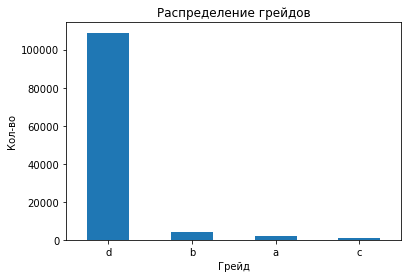

In [55]:
data["hdb_relend_client_credits_count_grade"].value_counts().plot(kind="bar", rot=0)
plt.xlabel("Грейд")
plt.ylabel("Кол-во")
plt.title("Распределение грейдов")
plt.show()

Получим, что большинство пользователей попадают под категорию другое - это грейд с литерой d. Дальше идут пользователи, у которых 1 кредит наличными и не более двух кредитных карт (b), за ними - пользователи с одним кредитом (a), выданным наличными. В конце располагются пользователи, которые взяли более одного кредита наличными (c)

Здесь пропущенные значения - это основа для создания нового признака, который будет отражать следующее: знаем ли мы грейд пользователя или нет.  
Остальные категории кодируются с помощью ohehot encoding с отбрасываем одного из столбцов, с целью исключения полной линейной зависимости между этими индикаторными фичами

Объединим два профиля - транзакционный и кредитный и посмотрим, сколько у нас абсолютно пустых профилей

In [56]:
round(
    (
        data[transactions_cols + credit_cols].isna().sum(axis=1) == len(transactions_cols + credit_cols)
    ).sum() / data.shape[0] * 100, 
    3
)

25.266

Получается, что примерно 25% пользователей не обладает никакой информацией о своих кредитных и транзакционных действиях

Третий профиль пользователей описывает их активность по различного вида счетам. Назовём это счётный профиль, который включает в себя такие признаки как: среднее за 3 месяца среднемесячных остатков на группе счетов ..., сумма средств клиента на группе счетов ..., разница между средним кредитным и дебетовым оборотом по ... и другие аналогичные.
Соберём эти признаки и посмотрим на 5 случайно отобранных пользователей

In [57]:
account_cols = list(filter(
    lambda x: (("rur" in x) and (not x.startswith("profit_income"))) or (x.startswith("diff")),
    list(set(data).difference(set(transactions_cols + credit_cols)))
))
account_cols.append("turn_save_db_avg_act_v2")
account_cols.append("turn_save_db_sum_v2")
account_cols.append("avg_cur_db_turn")
account_cols.append("avg_save_db_turn")
account_cols.append("turn_fdep_cr_avg_act_v2")
account_cols.append("avg_save_cr_turn")
account_cols.append("avg_cur_cr_turn")
account_cols.append("curbal_usd_amt_cm_avg")
len(account_cols)

30

In [58]:
data[account_cols].sample(5)

,curr_rur_amt_3m_avg,accum_rur_amt_3m_avg,sal_rur_amt_curr_v2,dda_rur_amt_3m_avg,curr_rur_amt_cm_avg,total_rur_amt_cm_avg,avg_credit_turn_rur,depos_rur_amt_cm_avg,tda_rur_amt_3m_avg,card_dda_rur_amt_curr_v2,...,dda_rur_amt_cm_avg,cred_dda_rur_amt_curr_v2,turn_save_db_avg_act_v2,turn_save_db_sum_v2,avg_cur_db_turn,avg_save_db_turn,turn_fdep_cr_avg_act_v2,avg_save_cr_turn,avg_cur_cr_turn,curbal_usd_amt_cm_avg
130072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,0.0,0.0,0.0,0.0,NaN,NaN,55891.0,NaN,0.0,0.0,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0
159091,5925.0,0.0,0.0,5925.0,18648.0,13848.0,69499.0,0.0,0.0,0.0,...,13848.0,0.0,NaN,NaN,17100.0,0.0,NaN,0.0,17000.0,102.0


Закрадывается подозрение, что в данных присутствуют пользователи, информация о действиях которых полностью занулена, потому что даже в третьем профиле находятся пользователи с совершенно пустым профилем.  
Объединим 3 профиля и посмотрим, сколько у нас пользователей, о которых мы ничего не знаем

In [59]:
round(
    (
        data[
            transactions_cols + credit_cols + account_cols
        ].isna().sum(axis=1) == len(transactions_cols + credit_cols + account_cols)
    ).sum() / data.shape[0] * 100, 
    3
)

22.824

Почти 23% пользователей не обладает абсолютно никакой информацией по своим трём профилям

Можно выделить ещё один профиль пользователя, который будет отражать его доходы. Данный профиль включается в себя такие признаки: средний операционный доход за 3/6/9/12 месяцев, среднемесячный доход от инвестиций/зарплаты и пособий/выплаты процентов, общий среднемесячный доход

In [60]:
income_cols = list(filter(
    lambda x: ("transaction" not in x) and (("income" in x) or ("inc" in x)),
    list(data)
))
len(income_cols)

8

Посмотрим, как обстоят дела с этим профилем у пользователей

In [61]:
data[income_cols].sample(5)

,profit_income_out_rur_amt_6m,profit_income_out_rur_amt_3m,profit_income_out_rur_amt_12m,profit_income_out_rur_amt_9m,avg_invest_inc,avg_percents_inc,total_inc,avg_zp_inc
225143,-607.666667,-743.333333,-71.333333,-236.444444,0.0,0.0,134254.0,246626.0
139266,11551.333333,17203.000000,9058.833333,9711.888889,0.0,0.0,86813.0,0.0
202017,7040.000000,7706.666667,8454.583333,8134.222222,0.0,0.0,191207.0,328970.0
174649,-183.333333,-281.000000,-87.083333,-115.333333,0.0,0.0,43508.0,0.0
252999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
round(
    (
        data[income_cols].isna().sum(axis=1) == len(income_cols)
    ).sum() / data.shape[0] * 100,
    3
)

23.987

Наблюдаем всё ту же картину - не по всем пользователям известна информация по доходному профилю (24% профилей доходных пусты).  
Посмотрим, как изменится процент пустых профилей при добавлении доходного профиля

In [63]:
round(
    (
        data[
            transactions_cols + credit_cols + account_cols + income_cols
        ].isna().sum(axis=1) == len(transactions_cols + credit_cols + account_cols + income_cols)
    ).sum() / data.shape[0] * 100, 
    3
)

22.824

Почти 23% пользователей, о действиях которых ничего неизвестно

Последний профиль, который можно выделить - это информационный, включащий в себя информацию по пользователю: статус по оттоку, страна, возраст, пол, наличие зп счёта, сегмент, причина попадания в сегмент, пол, пакет услуг, срок жизни в банке

In [64]:
info_cols = [
    "accountsalary_flag", "country", "clientoutflowstatus",
    "stratsegfactor", "srvpackage", "clientsegment", "age",
    "gender", "life_time_days"
]

data[info_cols].sample(5)

,accountsalary_flag,country,clientoutflowstatus,stratsegfactor,srvpackage,clientsegment,age,gender,life_time_days
138130,1.0,RUS,ACTIVE,Реальная зарплата клиента,Технический,MAFFLUENT,29.0,Мужской,3087.0
38876,0.0,RUS,ACTIVE,Инвестиционные продукты,Технический,AFFLUENT,41.0,Мужской,71.0
251304,1.0,RUS,ACTIVE,Остатки на счетах,Технический,MASS,31.0,Женский,1496.0
90282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
round(
    (
        data[info_cols].isna().sum(axis=1) == len(info_cols)
    ).sum() / data.shape[0] * 100,
    3
)

24.086

Интересно получается. Почти 24% пользователей полностью "обезличены", т.е. о них мы не знаем абсолютно никакой информации

Объединим все 5 профилей и посмотрим, сколько пользователей обладают информацией

In [66]:
profiles = []
for lst in [transactions_cols, credit_cols, account_cols, income_cols, info_cols]:
    profiles += lst
    
round(
    (
        data[profiles].isna().sum(axis=1) == len(profiles)
    ).sum() / data.shape[0] * 100, 
    3
)

22.824

Почти четверть всех профилей абсолютно пустые. Они нам не нужны, потому что по ним мы ничего сказать не можем

Построим распределение кол-ва пустых значений по всем пользователям

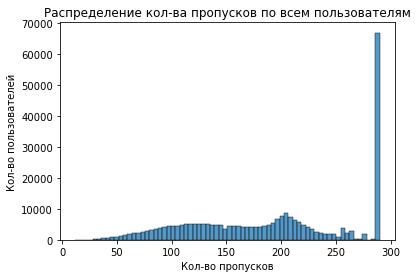

In [67]:
sns.histplot(data[profiles].isna().sum(axis=1).values)
plt.title("Распределение кол-ва пропусков по всем пользователям")
plt.xlabel("Кол-во пропусков")
plt.ylabel("Кол-во пользователей")
plt.show()

Удалять не будем, т.к. на них будет происходить обучение.

Файл с целевой переменной был загружен ранее, чтобы провести анализ и разметить данные. target_df - переменная, в которой хранится целевая переменная

Посмотрим на распределение целевой переменной

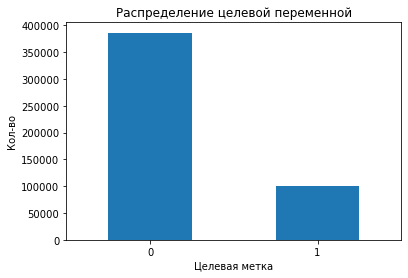

In [70]:
target_df["target"].value_counts().plot(kind="bar", rot=0)
plt.title("Распределение целевой переменной")
plt.xlabel("Целевая метка")
plt.ylabel("Кол-во")
plt.show()

Соотношение классов получается приблизительно 8:2. Имеем дело с сильно несбалансированными данными. Для борьбы/работы с такими данными можно использовать:
 - аргумент class_weight в определённых моделях, например, бустингах;
 - применить upsampling недостающего класса;
 - применить downsampling доминантного класса;
 - работать в таком ключе: представим, что все отобранные данные - это наша псевдо генеральная совокупность. Из неё мы n раз сэмплируем выборки равного объёма, допустим, 100_000, учитывая тот факт, что в каждой выборке соотношение классов должно быть одинаковым

Посмотрим на распределние таргета по признаку "наличие зарплатного счета у клиента на отчетную дату"

In [73]:
pd.crosstab(data["accountsalary_flag"], data["target"]).style.background_gradient("RdYlGn")

target,0.000000,1.000000
accountsalary_flag,,
0.000000,42649,938
1.000000,130247,44840


Из таблицы можно предположить, что эти переменные могут быть взаимосвязаны. Проверим эту гипотезу с помощью критерия $\chi^2$

In [74]:
scipy.stats.chisquare(
    pd.crosstab(data["accountsalary_flag"], data["target"])
).pvalue

array([0., 0.])

Получается, что переменные всё же взаимосвязаны. Значит, "accountsalary_flag" спокойно можно тянуть в модель для обучения

Аналогично проверим признак "gender"

In [75]:
pd.crosstab(data["gender"], data["target"]).style.background_gradient("RdYlGn")

target,0.000000,1.000000
gender,,
Женский,86330,17541
Мужской,86566,28237


In [76]:
scipy.stats.chisquare(
    pd.crosstab(data["gender"], data["target"]).values
).pvalue

array([0.5703269, 0.       ])

Получается, что если таргет == 1, то взаимосвязь между таргетом и полом существует, в противном случае - взаимосвязи нет

Следующей на проверку пойдет фича "hdb_relend_client_credits_count_grade"

In [77]:
pd.crosstab(data["hdb_relend_client_credits_count_grade"], data["target"]).T.style.background_gradient("RdYlGn")

hdb_relend_client_credits_count_grade,a,b,c,d
target,,,,
0.000000,1701,3526,689,81899
1.000000,309,680,106,25271


In [78]:
scipy.stats.chisquare(
    pd.crosstab(data["hdb_relend_client_credits_count_grade"], data["target"]).T.values
).pvalue

array([1.19375837e-211, 0.00000000e+000, 5.59450133e-095, 0.00000000e+000])

Обращая внимание на полученные порядки p-value, смело можно сделать вывод, что взаимосвязь между этими признаками есть

Теперь рассмотрим взаимосвязь "clientoutflowstatus" и таргета

In [79]:
pd.crosstab(data["clientoutflowstatus"], data["target"]).T.style.background_gradient("RdYlGn")

clientoutflowstatus,ACTIVE,LOCAL_WB,N2BANK_NEW,N2BANK_POTENTIAL,OUTFLOW,POTENTIAL,PREOUTFLOW,PREVYEARS_WB,SLEEP
target,,,,,,,,,
0.000000,139198,822,1237,857,1835,5572,2882,764,19729
1.000000,42265,126,400,251,168,754,280,208,1326


In [80]:
scipy.stats.chisquare(
    pd.crosstab(data["clientoutflowstatus"], data["target"]).T.values
).pvalue

array([0.00000000e+000, 3.86721012e-113, 4.51958324e-095, 4.66725060e-074,
       1.17053944e-303, 0.00000000e+000, 0.00000000e+000, 3.86887520e-071,
       0.00000000e+000])

Аналогичный описанному выше вывод применим и здесь - взаимосвязь имеет место

Зададимся вопросом, а существует ли взаимосвязь между "stratsegfactor" и таргета

In [81]:
pd.crosstab(data["stratsegfactor"], data["target"]).T.style.background_gradient("RdYlGn")

stratsegfactor,Зарплата из кредитной анкеты,Инвестиционные продукты,Остатки на счетах,Пакет услуг,Предиктивный доход,Реальная зарплата клиента
target,,,,,,
0.000000,19030,6494,85004,11189,27303,7858
1.000000,1243,1307,10956,17978,9936,3242


In [82]:
scipy.stats.chisquare(
    pd.crosstab(data["stratsegfactor"], data["target"]).T.values
).pvalue

array([0., 0., 0., 0., 0., 0.])

Смело можем ответить на вопрос, что взаимосвязь есть

А что насчёт связи между "clientsegment" и таргетом?

In [83]:
pd.crosstab(data["clientsegment"], data["target"]).T.style.background_gradient("RdYlGn")

clientsegment,A-CLUB,AFFLUENT,MAFFLUENT,MASS
target,,,,
0.000000,21,19632,43326,103938
1.000000,2320,20997,12746,9412


In [84]:
scipy.stats.chisquare(
    pd.crosstab(data["clientsegment"], data["target"]).T.values
).pvalue

array([0.00000000e+00, 1.27046523e-11, 0.00000000e+00, 0.00000000e+00])

Наблюдаем аналогичную картинку о наличии взаимосвязии

Посмотрим на распределение таргета по оставшимся категориальным признакам

In [85]:
pd.crosstab(data["country"], data["target"]).T.style.background_gradient("RdYlGn")

country,AGO,AND,ARG,ARM,AUT,AZE,BEL,BEN,BGR,BIH,BLR,BRA,CAN,CHE,CHN,CMR,DEU,DNK,ECU,EGY,ESP,EST,FIN,FJI,FRA,GBR,GEO,GHA,GRC,HUN,IND,IRL,IRQ,ISR,ITA,JOR,JPN,KAZ,KGZ,KOR,LTU,LVA,MDA,MEX,MNE,MWI,NLD,NZL,PAK,PER,PHL,POL,PSE,RUS,SEN,SGP,SRB,SVK,SVN,SWE,THA,TJK,TKM,TUR,TWN,UGA,UKR,USA,UZB,VEN,VNM,ZAF
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,2,0,0,39,3,9,0,0,0,0,381,1,0,0,12,1,13,1,1,3,0,5,2,1,4,3,0,1,3,0,4,3,1,15,13,1,1,91,357,3,6,9,13,1,1,1,0,2,1,0,1,0,1,171164,1,0,0,0,1,1,4,195,15,10,1,1,122,9,357,1,4,0
1.000000,0,2,2,10,2,4,1,1,1,2,83,0,1,2,1,0,18,0,0,0,2,7,1,0,3,8,1,0,0,1,4,0,0,19,6,0,0,43,6,0,4,13,7,2,1,0,2,0,0,1,0,1,0,45436,0,1,5,2,0,3,0,2,4,3,0,0,44,5,7,0,2,2


In [86]:
pd.crosstab(data["srvpackage"], data["target"]).T.style.background_gradient("RdYlGn")

srvpackage,X5Банк,А-Клуб,Альфа-Подписка,АльфаPriority,Класс,Комфорт,КомфортUltra,КомфортUltrafree,Комфортfree,Корпоративный,Максимум+,Максимум+free,МаксимумUltra,МаксимумUltrafree,Он-Лайф,Оптимум,ОптимумUltra,Премиум,Технический,Эконом,ЭкономUltra,длякредитовидепозитов
target,,,,,,,,,,,,,,,,,,,,,,
0.000000,15,21,8,4,2209,4342,231,133,38,8337,1913,179,91,522,343,22670,6687,5700,81670,19003,1256,17486
1.000000,2,2320,14,4,167,2436,129,81,11,1081,4431,307,201,779,43,3239,990,8647,19987,582,79,242


In [87]:
pd.crosstab(data["addrref"], data["target"]).T.style.background_gradient("RdYlGn")

addrref,Алтайский край,Архангельская область,Белгородская область,Владимирская область,Волгоградская область,Вологодская область,Воронежская область,Ивановская область,Иркутская область,Калининградская область,Калужская область,Кемеровская область - Кузбасс,Кировская область,Краснодарский край,Красноярский край,Курганская область,Курская область,Липецкая область,Московская область,Мурманская область,Нижегородская область,Новосибирская область,Омская область,Оренбургская область,Орловская область,Пензенская область,Пермский край,Приморский край,Псковская область,Республика Башкортостан,Республика Бурятия,Республика Карелия,Республика Коми,Республика Марий Эл,Республика Мордовия,Республика Саха (Якутия),Республика Татарстан (Татарстан),Республика Хакасия,Ростовская область,Рязанская область,Самарская область,Саратовская область,Сахалинская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тульская область,Тюменская область,Удмуртская Республика,Ульяновская область,Хабаровский край,Ханты-Мансийский автономный окр.,Челябинская область,Чувашская Респуб. - Чаваш Респуб.,Чувашская Республика - Чувашия,Ярославская область,г. Москва,г. Санкт - Петербург
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,2118,709,653,231,2195,1,2024,122,1835,1408,785,3235,13,7064,3294,496,306,1163,28,1037,3076,5071,3108,2941,1,781,2349,2009,527,3148,1,419,4,307,433,438,4385,395,4401,572,4259,1701,284,6738,711,877,1160,493,2381,1768,917,1270,2128,4613,265,671,1197,56663,14061
1.000000,372,314,123,17,423,0,377,19,397,730,91,615,2,1777,927,70,19,279,0,502,758,1411,660,454,0,96,580,885,98,430,0,110,0,36,34,58,523,58,822,52,737,193,146,1883,74,158,307,46,690,441,89,313,472,1138,36,96,239,19676,4090


Оценить здесь статистическую взаимосвязь между переменными можно с помощью критерия Фримана-Халтона, однако, реализации в питоне нет.  
Здесь можно предположить, что также получим взаимосвязь между переменными

Вывод после анализа перекрёстных таблиц такой:
 - все рассмотренные признаки можно брать в модель, т.к. они взаимосвязаны с таргетом, однако здесь не учитывается взаимосвязь между рассмотренными переменными
 
Отбор признаков можно будет потом произвести с помощью того же метода $\chi^2$

Отберём все количественные признаки

In [88]:
continious_cols = [
    col
    for col in list(data)
    if str(data[col].dtype).startswith("float") and (data[col].nunique() > 2)
]
len(continious_cols)

282

Выполним автоматическую проверку на нормальность распределения количественных данных

In [89]:
dist_check_res = [
    utils.check_distribution(data[col].fillna(0).values)
    for col in notebook.tqdm(continious_cols)
]

Counter(dist_check_res).most_common()

  0%|          | 0/282 [00:00<?, ?it/s]

[(1.0, 282)]

Получается, что все количественные признаки распределены ненормально

Для того, чтобы сравнить одну из мер центральной тенденции (среднее/медиана) по количественным признакам и таким образом сказать, имеет ли смысл брать этот признак в модель или нет, также необходимо провести проверку на гомогенность дисперсий рассматриваемых групп. Будем использовать критерий Левена, т.к. имеем дело со случаем сильного отклонения от нормального распределения исходных данных

In [90]:
levene_results = [
    utils.check_homogenity(
        data[data["target"] == 0][col].fillna(0).values,
        data[data["target"] == 1][col].fillna(0).values
    )
    for col in notebook.tqdm(continious_cols)
]

Counter(levene_results).most_common()

  0%|          | 0/282 [00:00<?, ?it/s]

[(1, 277), (0, 5)]

Посмотрим, что это за переменная, у которой дисперсии равны

In [91]:
continious_cols[np.asarray(levene_results).argmin()]

'hdb_other_active_min_psk'

In [92]:
print(data[data["target"] == 0]["hdb_bki_other_active_pil_month_payments_sum"].fillna(0).values.std())
print(data[data["target"] == 1]["hdb_bki_other_active_pil_month_payments_sum"].fillna(0).values.std())

65549.11654358164
573588.7958223381


В этом случае мы, действительно, получили, что дисперсии групп "hdb_bki_other_active_pil_month_payments_sum" однородны

Результаты проверки на гомогенность данных говорят о том, что дисперсии в двух группах (сплит по таргету) негомогенны. Учитывая этот факт, используем непараметрический тест Манна-Уитни для того, чтобы проверить, а есть ли статистически значимые различия в распределении этих двух группах. Если да, то такой признак хороший и его смело можно брать в модель, а если нет, то велика вероятность ошибочной классификации, т.к. функции распределения или значительно будут перекрывать друг друга или полностью будут наложены друг на друга

In [93]:
mann_whitneyu_res = [
    utils.mannwhitneyu_test(
        data[data["target"] == 0][col].fillna(0).values,
        data[data["target"] == 1][col].fillna(0).values
    )
    for col in notebook.tqdm(continious_cols)
]

Counter(mann_whitneyu_res).most_common()

  0%|          | 0/282 [00:00<?, ?it/s]

[(1, 280), (0, 2)]

По результатам теста оказалось, что для четырёх переменных имеются различия в кривых распределения. Отберём эти признаки и посмотрим на их кривые

In [94]:
mann_whitneyu_cols_check = [
    col
    for col in notebook.tqdm(continious_cols)
    if utils.mannwhitneyu_test(
        data[data["target"] == 0][col].fillna(0).values,
        data[data["target"] == 1][col].fillna(0).values
    ) != 1
]

mann_whitneyu_cols_check

  0%|          | 0/282 [00:00<?, ?it/s]

['hdb_other_active_mean_psk', 'hdb_bki_active_oth_cnt']

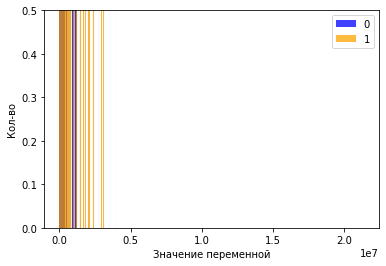

In [95]:
arr1 = data[
    data["target"] == 0
]["amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__perevody_s_karty_na_kartu"].fillna(0)
arr1 = arr1[arr1 != 0]

arr2 = data[
    data["target"] == 1
]["amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__perevody_s_karty_na_kartu"].fillna(0)
arr2 = arr2[arr2 != 0]

sns.histplot(arr1, color="blue", label='0')
sns.histplot(arr2, color="orange", label='1')
plt.ylim([0, 500])
plt.ylim([0, 0.5])
plt.legend(loc="upper right")
plt.xlabel("Значение переменной")
plt.ylabel("Кол-во")
plt.show()

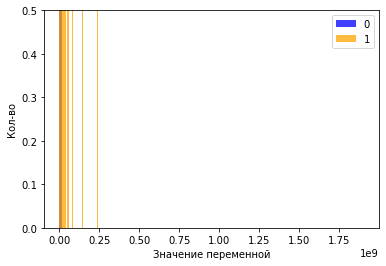

In [96]:
arr1 = data[
    data["target"] == 0
]["hdb_outstand_sum"].fillna(0)
arr1 = arr1[arr1 != 0]

arr2 = data[
    data["target"] == 1
]["hdb_outstand_sum"].fillna(0)
arr2 = arr2[arr2 != 0]

sns.histplot(arr1, color="blue", label='0')
sns.histplot(arr2, color="orange", label='1')
plt.ylim([0, 500])
plt.ylim([0, 0.5])
plt.legend(loc="upper right")
plt.xlabel("Значение переменной")
plt.ylabel("Кол-во")
plt.show()

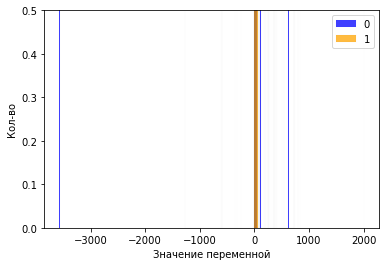

In [97]:
arr1 = data[
    data["target"] == 0
]["hdb_other_active_min_psk"].fillna(0)
arr1 = arr1[arr1 != 0]

arr2 = data[
    data["target"] == 1
]["hdb_other_active_min_psk"].fillna(0)
arr2 = arr2[arr2 != 0]

sns.histplot(arr1, color="blue", label='0')
sns.histplot(arr2, color="orange", label='1')
plt.ylim([0, 500])
plt.ylim([0, 0.5])
plt.legend(loc="upper right")
plt.xlabel("Значение переменной")
plt.ylabel("Кол-во")
plt.show()

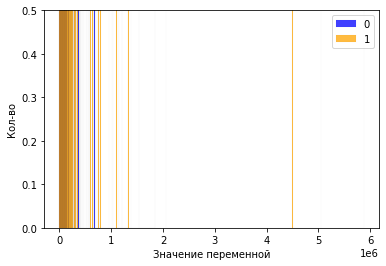

In [98]:
arr1 = data[
    data["target"] == 0
]["hdb_bki_other_active_ip_month_payments_sum"].fillna(0)
arr1 = arr1[arr1 != 0]

arr2 = data[
    data["target"] == 1
]["hdb_bki_other_active_ip_month_payments_sum"].fillna(0)
arr2 = arr2[arr2 != 0]

sns.histplot(arr1, color="blue", label='0')
sns.histplot(arr2, color="orange", label='1')
plt.ylim([0, 500])
plt.ylim([0, 0.5])
plt.legend(loc="upper right")
plt.xlabel("Значение переменной")
plt.ylabel("Кол-во")
plt.show()

Оказалось, что в этих случаях тест Манна-Уитни ошибся и никаких статистически значимых различий в распределениях нет

Т.к. тест Манна-Уитни не сравнивает средние значения, то сказать о статистической значимости различий в средних не представляется возможным. В нашем случае критерий Стьюдента применять тоже нельзя, как минимум, из-за нарушения предположения о гомогенности дисперсий рассматриваемых групп.  
Таким образом, сказать, значимы ли признаки или нет, можно будет, например, по важности признаков для модели или с помощью шап значений. В любом случае в модель берём все признаки, а дальше их обрабатываем так, чтобы повысить точность модели, уменьшить её пространственную сложность, а также уменьшить потребность в памяти для хранения обучаемых весов

Проверим количество оттока у разных групп

In [142]:
check_outflow = data.groupby(
    ["clientoutflowstatus", "target"],
    as_index=False
)["client_id"].count()

In [143]:
check_outflow

,clientoutflowstatus,target,client_id
0,ACTIVE,0.0,139195
1,ACTIVE,1.0,42265
2,LOCAL_WB,0.0,822
3,LOCAL_WB,1.0,126
4,N2BANK_NEW,0.0,1237
5,N2BANK_NEW,1.0,400
6,N2BANK_POTENTIAL,0.0,857
7,N2BANK_POTENTIAL,1.0,251
8,OUTFLOW,0.0,1835
9,OUTFLOW,1.0,168


Рассчитаем, какой процент отточных, предотточных клиентов занимает среди всех остальных пользователей

In [144]:
check_outflow["client_id"].sum()

218671

Всего людей у нас 218.671 тысяч, нужно расчитать, сколько всего клиентов, которые находятся в потенциальном оттоке, либо предотточны.

In [145]:
outflow = ["OUTFLOW", "POTENTIAL"]

In [146]:
check_outflow.query("clientoutflowstatus in @outflow")["client_id"].sum() 

8329

Таких людей 8.300, т.е. 3.8%.

Мы хотим знать, а какой процент от всех клиентов занимают люди, которым мы можем предложить семейный счёт и предотвратить отток. Т.е. посчитать процент предотточной целевой аудитории от всех клиентов.

In [147]:
check_outflow.query("clientoutflowstatus in @outflow and target == 1")["client_id"].sum()

922

922 клиента целевой аудитории являются предотточными, а это 0.42% всех клиентов, которые теряет банк.

Также мы хотим узнать, а какой процент от всей целевой аудитории занимает та, которая собирается уйти. Они составляют 11% от всей целевой аудитории.

Существуют пользователи, по которым есть дубликаты. Эти пользователи имеют разную информацию, считаю, что их нужно оставить.

In [99]:
dupl = data[data["client_id"].duplicated()]["client_id"].unique()
data.query("client_id in @dupl").loc[7, "client_id"]

'3b81e94ef29c045fb2bdbe118764d0d07c95d7baaaebf800e87a05d066a91de2'

In [100]:
data[
    data["client_id"] == "3b81e94ef29c045fb2bdbe118764d0d07c95d7baaaebf800e87a05d066a91de2"
]

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,cardapp_date,target
7,3b81e94ef29c045fb2bdbe118764d0d07c95d7baaaebf8...,2022-09-30,1.0,RUS,-712.666667,ACTIVE,190.0,Предиктивный доход,Технический,MAFFLUENT,...,1.0,NaN,NaN,0.000800,0.018205,0.007467,126.0,3.0,2021-05-24,0.0
233585,3b81e94ef29c045fb2bdbe118764d0d07c95d7baaaebf8...,2021-04-30,1.0,RUS,1213.166667,ACTIVE,146.0,Остатки на счетах,Технический,MASS,...,1.0,1.738095,NaN,0.001055,0.009932,0.002071,45.0,1.0,2021-05-24,0.0


Категории, которых мало, будем переводить в отдельную категорию - "Другое". Очень много пакетов услуг Технический, будто бы это карты для сотрудников, хотя есть Корпоративный пакет услуг.

In [101]:
package_other = data["srvpackage"].value_counts().tail(9).index

In [401]:
data["srvpackage"] = data["srvpackage"].progress_apply(
    lambda x: "Другое " if x in package_other else x
)

100%|██████████| 291882/291882 [00:00<00:00, 1215851.25it/s]


В таких признаках, как регион отделения и страна имеются категории, которые встречаются не очень часто, такие категории будут заменены на "Other", чтобы увеличить частоту встречаемости.

In [102]:
ref_other = data["addrref"].value_counts()[
    data["addrref"].value_counts() < 500
].index
country_other = data["country"].value_counts().head(1).index 

In [103]:
data["country"] = data["country"].progress_apply(
    lambda x: "OTHER " if x not in country_other else x
)
data["addrref"] = data["addrref"].progress_apply(
    lambda x: "OTH " if x in ref_other else x
)

100%|██████████| 291882/291882 [00:00<00:00, 1285528.11it/s]


Имеются клиенты банка, которым 14 лет, но они уже являются клиентами банка больше года, хотя клиентом можно стать с 14 лет, таких пользоватлей будем удалять.

In [408]:
data[(data["age"] == data["age"].min()) & (data["life_time_days"] > 360)]

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,cardapp_date,target
13109,ad1dc3fbb61b6a8760c3ab172f5579400aa27b71d6a04b...,2022-01-31,1.0,RUS,217.000000,ACTIVE,0.0,Предиктивный доход,Технический,MAFFLUENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-24,0.0
97784,d43931d12a529684ca5fce0e053af69ba53a96a1d9d34f...,2022-11-30,0.0,RUS,2298.333333,ACTIVE,0.0,Предиктивный доход,длякредитовидепозитов,MAFFLUENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-08,0.0
118074,bc978475e9403b27ddf3a7f1ca56c090f752f9f6dd7bc3...,2022-07-31,1.0,RUS,1276.333333,ACTIVE,3977.0,Остатки на счетах,Технический,MASS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-08,0.0


Удаляю ненужные строчки

In [104]:
data = data.drop(
    data[(data["age"] == data["age"].min()) & (data["life_time_days"] > 360)].index
).reset_index(drop=True)

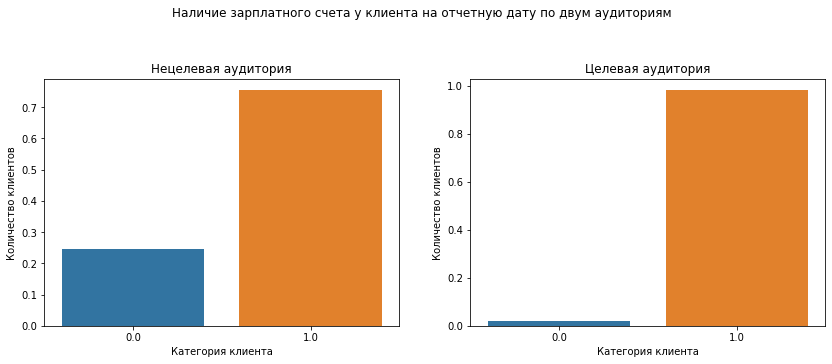

In [106]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.suptitle("Наличие зарплатного счета у клиента на отчетную дату по двум аудиториям")
sns.barplot(
    x=data[data["target"] == 0]["accountsalary_flag"].value_counts(normalize=True).index, 
    y=data[data["target"] == 0]["accountsalary_flag"].value_counts(normalize=True).values
);
plt.title("Нецелевая аудитория");
plt.xlabel("Категория клиента");
plt.ylabel("Количество клиентов");
plt.subplot(2, 2, 2)
plt.title("Целевая аудитория");
sns.barplot(
    x=data[data["target"] == 1]["accountsalary_flag"].value_counts(normalize=True).index, 
    y=data[data["target"] == 1]["accountsalary_flag"].value_counts(normalize=True).values
);         
plt.xlabel("Категория клиента");
plt.ylabel("Количество клиентов");

Из графика четко видно, что целевая аудитория почти не имеет людей, которые не имеют зарплатного счета на отчетную дату, в отличие от нецелевой аудитории.

Проверим отрицательные значения в столбцах

In [107]:
cat_feature = [i for i in data.columns if data[i].dtypes == 'O']

In [108]:
data_num = data.drop(cat_feature, axis=1).copy()
data_num = data_num.drop(["cardapp_date", "dt"], axis=1)

In [109]:
for column in data_num.columns:
    if data_num[data_num[column] < 0].shape[0] > 0:
        print(f"{column} - {data_num[data_num[column] < 0].shape[0]} значений")

profit_income_out_rur_amt_6m - 33498 значений
profit_income_out_rur_amt_3m - 38407 значений
profit_income_out_rur_amt_12m - 28239 значений
profit_income_out_rur_amt_9m - 30371 значений
diff_save_cr_db_turn - 22420 значений
diff_cur_cr_db_turn - 69386 значений
hdb_other_active_min_psk - 11 значений
hdb_other_active_mean_psk - 4 значений


Есть отрицательные значения в в столбцах, но важны 2 последних столбца - они связаны с ПСК(полная стоимость кредита), которая не может быть отрицательной, заменим эти значения на 0.

In [110]:
data[data["hdb_other_active_min_psk"] < 0]["hdb_other_active_min_psk"] = 0
data[data["hdb_other_active_mean_psk"] < 0]["hdb_other_active_mean_psk"] = 0

In [111]:
data.sample(5)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,cardapp_date,target
141248,df28966e04536d565032ed3f8f6ebd30d02a0c4d03af1e...,2021-02-28,1.0,RUS,57.666667,SLEEP,0.0,NaN,Корпоративный,MASS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-28,0.0
114142,aa730bee600b316de1af67295e76f3833eb9f60f6ea3d8...,2022-12-31,1.0,RUS,480.666667,ACTIVE,80.0,Остатки на счетах,Оптимум,MASS,...,NaN,NaN,NaN,NaN,0.000527,NaN,3.0,NaN,2017-10-09,0.0
104155,0ab48752502475e8024c28c89878b176b9b47ec353dc33...,2021-10-31,0.0,RUS,905.000000,SLEEP,0.0,NaN,Эконом,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-11,0.0
145137,457636a6e1b51f8a337f75d60cc97051567f217237d59a...,2021-04-30,1.0,RUS,31326.000000,ACTIVE,12034.0,Пакет услуг,Максимум+,AFFLUENT,...,NaN,NaN,NaN,0.012921,0.002361,0.058925,93.0,3.0,2019-07-08,1.0
224016,61464201f04e6df86ebcbc901b0521c53f2b58b275ff59...,2022-08-31,1.0,RUS,661.666667,ACTIVE,31.0,Остатки на счетах,Технический,MASS,...,NaN,NaN,NaN,0.007539,NaN,NaN,NaN,NaN,2022-09-28,0.0


<h1 align="center">Предсказание на отложенной выборке</h1><h1 align="center"></h1>

In [150]:
model = joblib.load("models/fin_lgb.pkl")

In [151]:
valid = pd.read_csv("test_set/feat_cup_val_alfa.csv")
score_df = pd.read_csv("test_set/score_file.csv")

In [152]:
valid_pre = valid.drop(["client_id", "dt", "clientoutflowstatus"], axis=1)

In [153]:
valid_pre["srvpackage"] = valid_pre["srvpackage"].progress_apply(
    lambda x: "Другое " if x in package_other else x
)
valid_pre["country"] = valid_pre["country"].progress_apply(
    lambda x: "OTHER " if x not in country_other else x
)
valid_pre["addrref"] = valid_pre["addrref"].progress_apply(
    lambda x: "OTH " if x in ref_other else x
)

100%|██████████| 28919/28919 [00:00<00:00, 1156314.49it/s]


In [154]:
cat_col = [i for i in valid_pre.columns if valid_pre[i].dtypes == 'O']

In [155]:
for col in cat_col:
    valid_pre[col].fillna(valid_pre[col].mode()[0], inplace=True)
    
valid_pre[cat_col].isna().sum().sum()

0

In [156]:
valid_pre = pd.get_dummies(data=valid_pre, columns=cat_col, drop_first=True, dtype=np.uint8)
valid_pre = valid_pre.fillna(0)

In [157]:
valid_pre.shape

(28919, 354)

In [164]:
predict = model.predict_proba(valid_pre)[:, 1]

In [170]:
score_df["score"] = predict

In [172]:
score_df.to_csv("predict.csv", index=False)